In [4]:
!unzip 'archive (4).zip'

Archive:  archive (4).zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


In [6]:
!rm 'archive (4).zip'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('twitter_training.csv')

In [4]:
df.head(2)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [5]:
df['Positive'].value_counts()

Positive
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [6]:
category={'Negative':3,
          'Neutral':1,
          'Positive':2,
          'Irrelevant':0
          }
df['class']=df['Positive'].map(category)
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",class
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,2
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,2
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,2
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 5 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
 4   class                                                  74681 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.8+ MB


In [8]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 5 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   73995 non-null  int64 
 1   Borderlands                                            73995 non-null  object
 2   Positive                                               73995 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
 4   class                                                  73995 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.4+ MB


In [9]:
x=df['im getting on borderlands and i will murder you all ,'].values
y=df['class'].values
x=x[:13740]
y=y[:13740]

In [10]:
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')

x shape: (13740,)
y shape: (13740,)


In [13]:
from collections import Counter
Counter(y)

Counter({2: 4092, 1: 3121, 3: 3971, 0: 2556})

In [14]:
test=pd.read_csv('twitter_validation.csv')

In [15]:
test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [16]:
X_test=test['I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'].values

In [17]:
test['class']=test['Irrelevant'].map(category)
y_test=test['class'].values

In [18]:
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_test shape: (999,)
y_test shape: (999,)


In [19]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [20]:
oneHot=CountVectorizer()
x_train_one_hot=oneHot.fit_transform(x)
x_test_one_hot=oneHot.transform(X_test)

In [50]:
x_train_one_hot.shape

(13740, 10442)

In [21]:
print(x_train_one_hot.shape)
print(x_test_one_hot.shape)

(13740, 10442)
(999, 10442)


In [22]:
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [23]:
train_ds = SentimentData(X= x_train_one_hot, y = y)
test_ds = SentimentData(x_test_one_hot, y_test)

In [24]:
BATCH_SIZE = 512
NUM_EPOCHS = 80

In [25]:
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [26]:
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [28]:
model = SentimentModel(NUM_FEATURES = x_train_one_hot.shape[1], NUM_CLASSES = 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [29]:
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")


Epoch 0, Loss: 36.199700355529785
Epoch 1, Loss: 33.49734437465668
Epoch 2, Loss: 30.281944751739502
Epoch 3, Loss: 26.88855344057083
Epoch 4, Loss: 23.60308289527893
Epoch 5, Loss: 20.602278232574463
Epoch 6, Loss: 18.02777725458145
Epoch 7, Loss: 15.862629234790802
Epoch 8, Loss: 14.083238661289215
Epoch 9, Loss: 12.603808045387268
Epoch 10, Loss: 11.369743406772614
Epoch 11, Loss: 10.328027695417404
Epoch 12, Loss: 9.452209651470184
Epoch 13, Loss: 8.70604920387268
Epoch 14, Loss: 8.059754312038422
Epoch 15, Loss: 7.502462282776833
Epoch 16, Loss: 7.015297889709473
Epoch 17, Loss: 6.588770240545273
Epoch 18, Loss: 6.211054399609566
Epoch 19, Loss: 5.868430882692337
Epoch 20, Loss: 5.569030523300171
Epoch 21, Loss: 5.30281700193882
Epoch 22, Loss: 5.058799237012863
Epoch 23, Loss: 4.8416997641325
Epoch 24, Loss: 4.638127088546753
Epoch 25, Loss: 4.459672302007675
Epoch 26, Loss: 4.292569138109684
Epoch 27, Loss: 4.141125284135342
Epoch 28, Loss: 4.006588019430637
Epoch 29, Loss: 3.86

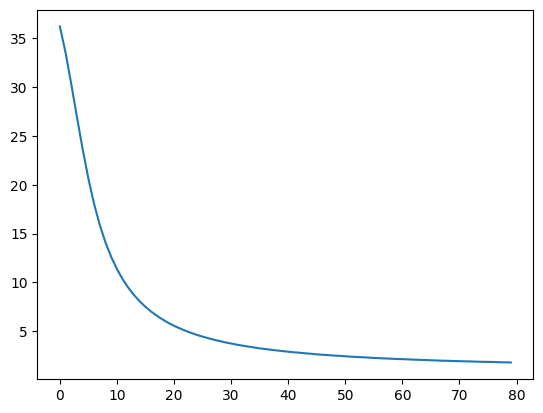

In [30]:
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)
plt.show()

In [31]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)


In [32]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [33]:
acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."

'The accuracy of the model is 51.2%.'

In [34]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 28.5 %


<Axes: >

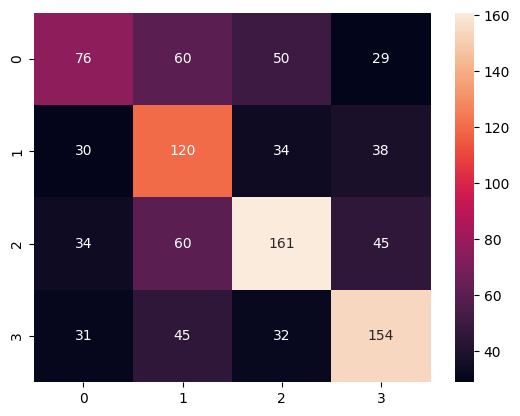

In [35]:
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")

In [36]:
model2 = SentimentModel(NUM_FEATURES = x_train_one_hot.shape[1], NUM_CLASSES = 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters())
NUM_EPOCHS=150

train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model2(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

Epoch 0, Loss: 36.251458168029785
Epoch 1, Loss: 33.05644500255585
Epoch 2, Loss: 29.606698751449585
Epoch 3, Loss: 26.219314336776733
Epoch 4, Loss: 23.030887722969055
Epoch 5, Loss: 20.18555098772049
Epoch 6, Loss: 17.73308628797531
Epoch 7, Loss: 15.66025596857071
Epoch 8, Loss: 13.941962093114853
Epoch 9, Loss: 12.491469621658325
Epoch 10, Loss: 11.287749618291855
Epoch 11, Loss: 10.276436865329742
Epoch 12, Loss: 9.406758576631546
Epoch 13, Loss: 8.672411382198334
Epoch 14, Loss: 8.040884792804718
Epoch 15, Loss: 7.478685602545738
Epoch 16, Loss: 6.99598403275013
Epoch 17, Loss: 6.566289633512497
Epoch 18, Loss: 6.186317071318626
Epoch 19, Loss: 5.856777846813202
Epoch 20, Loss: 5.5548105686903
Epoch 21, Loss: 5.289225175976753
Epoch 22, Loss: 5.0408888310194016
Epoch 23, Loss: 4.824283346533775
Epoch 24, Loss: 4.626545026898384
Epoch 25, Loss: 4.444880396127701
Epoch 26, Loss: 4.282451316714287
Epoch 27, Loss: 4.120269000530243
Epoch 28, Loss: 3.9868562668561935
Epoch 29, Loss: 3

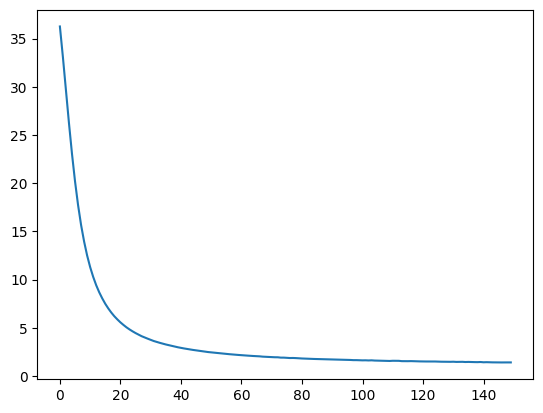

In [37]:
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)
plt.show()

In [38]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model2(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)


In [39]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [40]:
acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."

'The accuracy of the model is 49.1%.'

In [41]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 28.5 %


<Axes: >

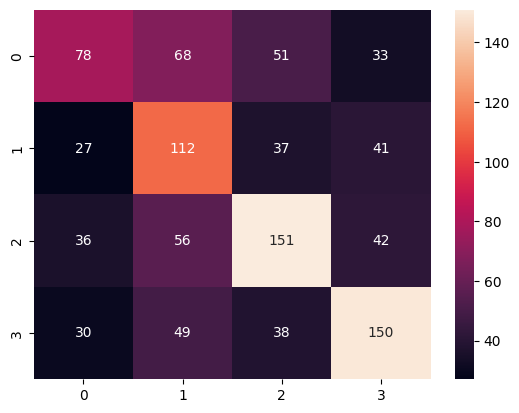

In [42]:
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")

In [56]:
x=df['im getting on borderlands and i will murder you all ,'].values
y=df['class'].values
print(x.shape , y.shape)
x=x[13740:]
y=y[13740:]

(73995,) (73995,)


In [57]:
x.shape , y.shape

((60255,), (60255,))

In [58]:
Counter(y)

Counter({2: 16562, 1: 14987, 3: 18387, 0: 10319})

In [59]:
x_train_one_hot2=oneHot.fit_transform(x)

In [60]:
x_train_one_hot2.shape

(60255, 27486)

In [ ]:
train_ds2 = SentimentData(X= x_train_one_hot2, y = y)
train_loader2 = DataLoader(dataset=train_ds2, batch_size=BATCH_SIZE, shuffle=True)

In [52]:
model = SentimentModel(NUM_FEATURES = x_train_one_hot2.shape[1], NUM_CLASSES = 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader2:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")
